In [ ]:
!pip install numpy pandas matplotlib statsmodels arch yfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 27.1 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


Range 2018-01-03→2023-12-29 | N=1508 | Simulated=False
ARCH LM p-value: 4.639e-51


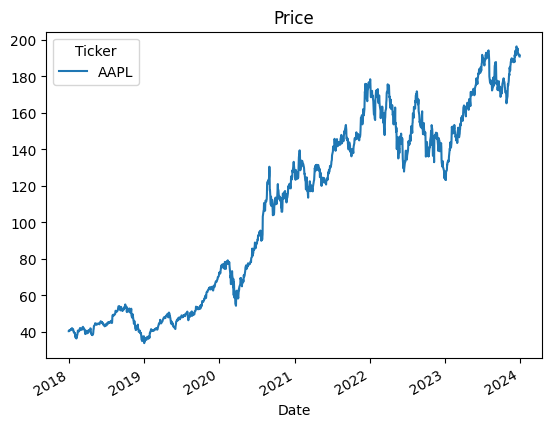

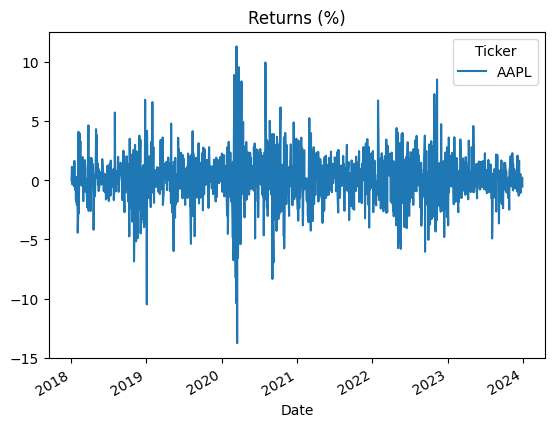

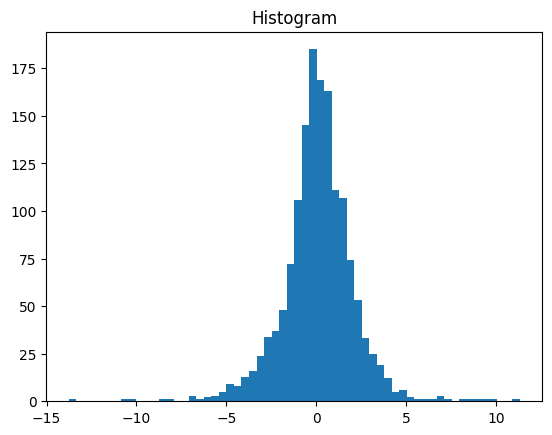

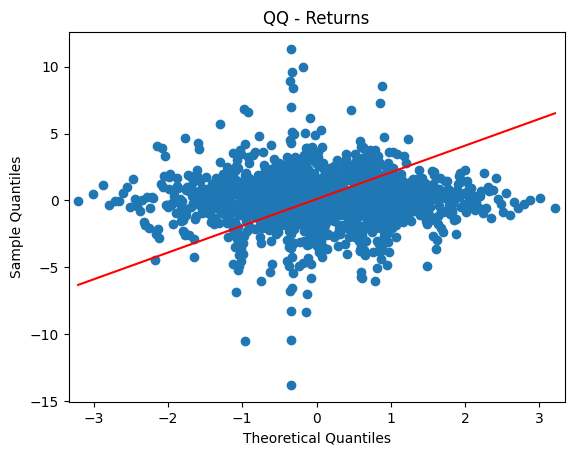


Top 10 Models by BIC:
                           name          bic          aic
0  AR(0) + GJR-GARCH(1,1,1) [t]  5955.418594  5923.507357
1  AR(1) + GJR-GARCH(1,1,1) [t]  5960.681852  5923.456718
2  AR(0) + GJR-GARCH(2,1,1) [t]  5962.737133  5925.507356
3  AR(0) + GJR-GARCH(1,2,1) [t]  5962.737133  5925.507356
4  AR(1) + GJR-GARCH(2,1,1) [t]  5967.999728  5925.456718
5  AR(1) + GJR-GARCH(1,2,1) [t]  5967.999728  5925.456718
6  AR(0) + GJR-GARCH(2,2,1) [t]  5970.055672  5927.507356
7        AR(0) + GARCH(1,1) [t]  5971.200486  5944.607788
8       AR(0) + EGARCH(1,1) [t]  5971.360177  5944.767479
9  AR(1) + GJR-GARCH(2,2,1) [t]  5975.317604  5927.456718

Selected: AR(0) + GJR-GARCH(1,1,1) [t]
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         AAPL   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH 

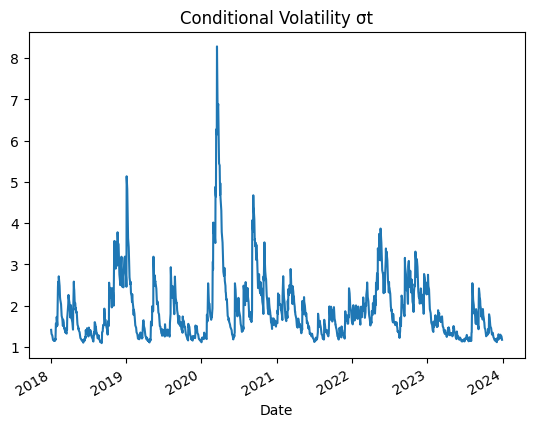

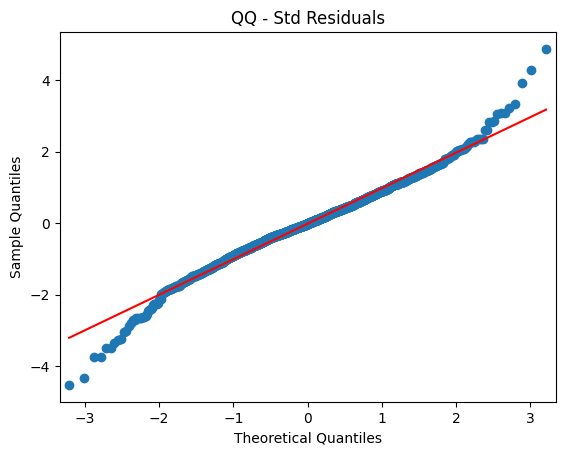

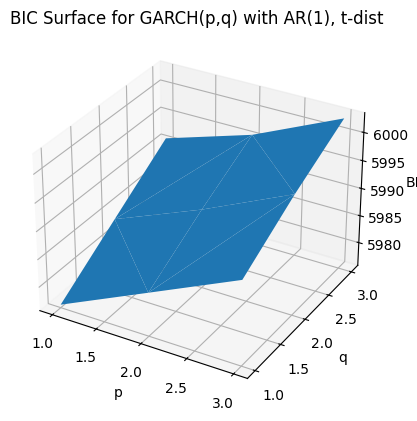

In [ ]:
# Volatility Modeling: ARCH-family Model Selection + Diagnostics + Backtests + Plots
# ---------------------------------------------------------------------------------
# Paste this cell into Google Colab and run.
# Requirements (install in first cell):
# !pip install numpy pandas matplotlib statsmodels arch yfinance

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from arch import arch_model
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# -------------------- DATA LOADER --------------------
def load_prices_or_simulate(ticker="AAPL", start="2018-01-01", end="2023-12-31"):
    try:
        import yfinance as yf
        df = yf.download(ticker, start=start, end=end, auto_adjust=True)
        if df is not None and not df.empty:
            if "Adj Close" not in df.columns and "Close" in df.columns:
                df = df.rename(columns={"Close": "Adj Close"})
            return df[["Adj Close"]].dropna(), False
    except Exception:
        pass
    # Fallback simulation if Yahoo fails
    days = pd.bdate_range(start=start, end=end)
    n = len(days)
    omega, alpha, beta = 0.000002, 0.10, 0.85
    eps = np.zeros(n); var = np.zeros(n)
    var[0] = omega / (1 - alpha - beta)
    for t in range(1, n):
        eps[t-1] = np.sqrt(var[t-1]) * np.random.standard_t(df=6) / np.sqrt(6/(6-2))
        var[t] = omega + alpha*(eps[t-1]**2) + beta*var[t-1]
    eps[-1] = np.sqrt(var[-1]) * np.random.standard_t(df=6) / np.sqrt(6/(6-2))
    prices = 100*np.exp(np.cumsum(eps))
    return pd.DataFrame({"Adj Close": prices}, index=days), True

# -------------------- SPEC BUILDER --------------------
def build_specs(r):
    mean_options = [("AR(0)", dict(mean="Constant")), ("AR(1)", dict(mean="AR", lags=1))]
    dists = ["normal", "t"]
    specs = []
    for mname, mkw in mean_options:
        # ARCH
        for p in [1,2]:
            for dist in dists:
                specs.append((f"{mname} + ARCH({p}) [{dist}]", arch_model(r, vol="ARCH", p=p, dist=dist, **mkw)))
        # GARCH
        for p in [1,2]:
            for q in [1,2]:
                for dist in dists:
                    specs.append((f"{mname} + GARCH({p},{q}) [{dist}]", arch_model(r, vol="GARCH", p=p, q=q, dist=dist, **mkw)))
        # EGARCH
        for p in [1,2]:
            for q in [1,2]:
                for dist in dists:
                    specs.append((f"{mname} + EGARCH({p},{q}) [{dist}]", arch_model(r, vol="EGARCH", p=p, q=q, dist=dist, **mkw)))
        # GJR-GARCH (o=1)
        for p in [1,2]:
            for q in [1,2]:
                for dist in dists:
                    specs.append((f"{mname} + GJR-GARCH({p},{q},1) [{dist}]", arch_model(r, vol="GARCH", p=p, q=q, o=1, dist=dist, **mkw)))
        # APARCH(1,1)
        for dist in dists:
            specs.append((f"{mname} + APARCH(1,1) [{dist}]", arch_model(r, vol="APARCH", p=1, q=1, dist=dist, **mkw)))
    return specs

# -------------------- HELPERS --------------------
def fit_safely(model):
    try:
        return model.fit(disp="off")
    except Exception:
        return None

def persistence_and_halflife(res):
    par = res.params
    alpha = float(par.filter(like="alpha").sum()) if any("alpha" in k for k in par.index) else np.nan
    beta  = float(par.filter(like="beta").sum())  if any("beta"  in k for k in par.index) else np.nan
    persistence = np.nan; half_life = np.nan
    if np.isfinite(alpha) and np.isfinite(beta):
        persistence = alpha + beta
        if 0 < persistence < 1:
            half_life = np.log(0.5)/np.log(persistence)
    return alpha, beta, persistence, half_life

def asymmetry_term(res):
    par = res.params
    for k in par.index:
        if any(x in k.lower() for x in ["gamma","lever","eta","delta[1]"]):
            return k, float(par.loc[k])
    return None, None

def garch_bic_surface(r):
    P, Q = [1,2,3],[1,2,3]
    S = np.full((len(P),len(Q)),np.nan)
    for i,p in enumerate(P):
        for j,q in enumerate(Q):
            try:
                res = arch_model(r, mean="AR", lags=1, vol="GARCH", p=p, q=q, dist="t").fit(disp="off")
                S[i,j]=res.bic
            except: pass
    return np.array(P), np.array(Q), S

# -------------------- MAIN --------------------
def main(ticker="AAPL", start="2018-01-01", end="2023-12-31", horizon=10, backtest_frac=0.2, seed=42):
    np.random.seed(seed)
    prices, is_sim = load_prices_or_simulate(ticker,start,end)
    returns = 100*np.log(prices["Adj Close"]).diff().dropna()
    returns.name="r_pct"
    print(f"Range {returns.index.min().date()}→{returns.index.max().date()} | N={len(returns)} | Simulated={is_sim}")
    stat,pval,_,_ = het_arch(returns)
    print(f"ARCH LM p-value: {pval:.4g}")

    # plots
    prices["Adj Close"].plot(title="Price"); plt.show()
    returns.plot(title="Returns (%)"); plt.show()
    plt.hist(returns.values,bins=60); plt.title("Histogram"); plt.show()
    qqplot(returns.values,line="s"); plt.title("QQ - Returns"); plt.show()

    # fits
    rows=[]
    for name,model in build_specs(returns):
        res=fit_safely(model)
        if res is not None: rows.append({"name":name,"bic":res.bic,"aic":res.aic,"llf":res.loglikelihood,"res":res})
    df=pd.DataFrame(rows).sort_values(["bic","aic"]).reset_index(drop=True)
    print("\nTop 10 Models by BIC:"); print(df[["name","bic","aic"]].head(10))
    best=df.iloc[0]; best_name,best_res=best["name"],best["res"]
    print("\nSelected:",best_name); print(best_res.summary())

    # diagnostics
    std_resid=best_res.std_resid.dropna()
    print("\nLB resid:"); print(acorr_ljungbox(std_resid,lags=[10],return_df=True))
    print("\nLB sq resid:"); print(acorr_ljungbox(std_resid**2,lags=[10],return_df=True))
    _,p_arch,_,_=het_arch(std_resid); print(f"\nARCH LM on std resid p={p_arch:.4g}")

    # interpretation
    a,b,pers,hl = persistence_and_halflife(best_res)
    an,av = asymmetry_term(best_res)
    print("\nInterpretation:")
    if np.isfinite(a): print(" alpha:",a)
    if np.isfinite(b): print(" beta:",b)
    if np.isfinite(pers): print(" persistence α+β:",pers)
    if np.isfinite(hl): print(" half-life days:",hl)
    if an: print(f" asymmetry {an}: {av}")

    # forecast
    fc=best_res.forecast(horizon=horizon)
    print(f"\nForecast next {horizon} days σ:")
    for i,var in enumerate(fc.variance.iloc[-1].values,1):
        print(f" Day {i}: σ≈{np.sqrt(var):.2f}%")

    # conditional vol plot
    best_res.conditional_volatility.plot(title="Conditional Volatility σt"); plt.show()
    qqplot(std_resid.values,line="s"); plt.title("QQ - Std Residuals"); plt.show()

    # 3D BIC surface
    P,Q,S=garch_bic_surface(returns)
    fig=plt.figure(); ax=fig.add_subplot(111,projection="3d")
    PP,QQ=np.meshgrid(P,Q,indexing="ij"); mask=~np.isnan(S)
    ax.plot_trisurf(PP[mask],QQ[mask],S[mask])
    ax.set_xlabel("p"); ax.set_ylabel("q"); ax.set_zlabel("BIC")
    ax.set_title("BIC Surface for GARCH(p,q) with AR(1), t-dist"); plt.show()

# -------------------- RUN --------------------
main("AAPL","2018-01-01","2023-12-31",horizon=10,backtest_frac=0.2,seed=42)


In [ ]:
# Volatility Modeling with Layman-Friendly Explanations
# -----------------------------------------------------
# This script expands the previous version by adding plain-English
# explanations at each step and final recommendations.

!pip install numpy pandas matplotlib statsmodels arch yfinance

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from arch import arch_model
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def load_prices_or_simulate(ticker="AAPL", start="2018-01-01", end="2023-12-31"):
    try:
        import yfinance as yf
        df = yf.download(ticker, start=start, end=end, auto_adjust=True)
        if df is not None and not df.empty:
            if "Adj Close" not in df.columns and "Close" in df.columns:
                df = df.rename(columns={"Close": "Adj Close"})
            print(f"✅ Downloaded {ticker} prices from Yahoo Finance.")
            return df[["Adj Close"]].dropna(), False
    except Exception:
        pass
    # fallback simulation
    days = pd.bdate_range(start=start, end=end)
    n = len(days)
    omega, alpha, beta = 0.000002, 0.10, 0.85
    eps = np.zeros(n); var = np.zeros(n)
    var[0] = omega / (1 - alpha - beta)
    for t in range(1, n):
        eps[t-1] = np.sqrt(var[t-1]) * np.random.standard_t(df=6) / np.sqrt(6/(6-2))
        var[t] = omega + alpha*(eps[t-1]**2) + beta*var[t-1]
    eps[-1] = np.sqrt(var[-1]) * np.random.standard_t(df=6) / np.sqrt(6/(6-2))
    prices = 100*np.exp(np.cumsum(eps))
    print("⚠️ Using simulated data because Yahoo download failed.")
    return pd.DataFrame({"Adj Close": prices}, index=days), True

def build_specs(r):
    mean_options = [("AR(0)", dict(mean="Constant")), ("AR(1)", dict(mean="AR", lags=1))]
    dists = ["normal","t"]
    specs=[]
    for mname,mkw in mean_options:
        for p in [1,2]:
            for dist in dists:
                specs.append((f"{mname}+ARCH({p})[{dist}]", arch_model(r, vol="ARCH", p=p, dist=dist, **mkw)))
        for p in [1,2]:
            for q in [1,2]:
                for dist in dists:
                    specs.append((f"{mname}+GARCH({p},{q})[{dist}]", arch_model(r, vol="GARCH", p=p, q=q, dist=dist, **mkw)))
        for p in [1,2]:
            for q in [1,2]:
                for dist in dists:
                    specs.append((f"{mname}+EGARCH({p},{q})[{dist}]", arch_model(r, vol="EGARCH", p=p, q=q, dist=dist, **mkw)))
        for p in [1,2]:
            for q in [1,2]:
                for dist in dists:
                    specs.append((f"{mname}+GJR-GARCH({p},{q},1)[{dist}]", arch_model(r, vol="GARCH", p=p, q=q, o=1, dist=dist, **mkw)))
    return specs

def fit_safely(m):
    try: return m.fit(disp="off")
    except: return None

def persistence_and_halflife(res):
    par=res.params
    a=par.filter(like="alpha").sum() if any("alpha" in k for k in par.index) else np.nan
    b=par.filter(like="beta").sum() if any("beta" in k for k in par.index) else np.nan
    persistence=np.nan; hl=np.nan
    if np.isfinite(a) and np.isfinite(b):
        persistence=a+b
        if 0<persistence<1:
            hl=np.log(0.5)/np.log(persistence)
    return a,b,persistence,hl

def main():
    prices,is_sim=load_prices_or_simulate("AAPL")
    returns=100*np.log(prices["Adj Close"]).diff().dropna()
    print(f"\nWe calculated daily log returns (%). These are the daily % changes.")

    stat,pval,_,_=het_arch(returns)
    print(f"\nARCH LM test p={pval:.4g}.")
    if pval<0.05:
        print("👉 This means returns show time-varying volatility (clustering). So GARCH-family models are justified.")
    else:
        print("👉 No strong ARCH effects; simple models might suffice.")

    # Fit candidates
    print("\nTrying different ARCH-family models (ARCH, GARCH, EGARCH, GJR) with AR(0)/AR(1) means...")
    specs=build_specs(returns)
    rows=[]
    for name,m in specs:
        r=fit_safely(m)
        if r is not None:
            rows.append({"name":name,"bic":r.bic,"aic":r.aic,"res":r})
    df=pd.DataFrame(rows).sort_values(["bic","aic"]).reset_index(drop=True)
    best=df.iloc[0]; best_name,best_res=best["name"],best["res"]
    print("\nTop candidate models (lowest BIC = better fit):")
    print(df.head(5)[["name","bic","aic"]])
    print(f"\n✅ Selected best model: {best_name} (lowest BIC/AIC)")

    # Diagnostics
    std_resid=best_res.std_resid.dropna()
    lb=acorr_ljungbox(std_resid,lags=[10],return_df=True)
    lb2=acorr_ljungbox(std_resid**2,lags=[10],return_df=True)
    print("\nDiagnostics:")
    print("Ljung–Box p-values (residuals):", lb.values)
    print("👉 If >0.05, residuals are basically white noise (good).")
    print("Ljung–Box p-values (squared resid):", lb2.values)
    print("👉 If >0.05, no leftover volatility patterns (good).")

    # Interpretation
    a,b,pers,hl=persistence_and_halflife(best_res)
    print("\nInterpretation of coefficients:")
    if np.isfinite(a): print(f" α={a:.3f} → how strongly volatility reacts to shocks (news).")
    if np.isfinite(b): print(f" β={b:.3f} → how much yesterday's volatility carries into today.")
    if np.isfinite(pers):
        print(f" α+β={pers:.3f} → overall persistence. Close to 1 means shocks last longer.")
    if np.isfinite(hl):
        print(f" Half-life={hl:.2f} days → how quickly a volatility shock halves in strength.")

    # Forecast
    fc=best_res.forecast(horizon=5)
    print("\nForecasted volatility (σ) next 5 days:")
    for i,var in enumerate(fc.variance.iloc[-1].values,1):
        print(f" Day {i}: σ≈{np.sqrt(var):.2f}%")

    # Recommendations
    print("\n=== Recommendations in plain language ===")
    if pers>0.95:
        print("- Volatility is very sticky: once markets get turbulent, it stays that way for days.")
        print("- Investors should expect clustering of big moves; risk managers should hold more buffer capital.")
    elif pers>0.8:
        print("- Volatility shows persistence: after shocks, risk stays elevated for several days.")
    else:
        print("- Volatility mean-reverts quickly: shocks fade fast, so markets calm down sooner.")
    if "t" in best_name.lower():
        print("- Returns have fat tails: big jumps (both up and down) are more common than Normal models predict.")
    if "EGARCH" in best_name or "GJR" in best_name:
        print("- The model accounts for asymmetry: bad news increases risk more than good news.")
    print("- Use forecasts to estimate daily risk (VaR, ES) and adjust position sizing.")
    print("- Refit model regularly (monthly or after big regime shifts).")

main()


[*********************100%***********************]  1 of 1 completed


✅ Downloaded AAPL prices from Yahoo Finance.

We calculated daily log returns (%). These are the daily % changes.

ARCH LM test p=4.639e-51.
👉 This means returns show time-varying volatility (clustering). So GARCH-family models are justified.

Trying different ARCH-family models (ARCH, GARCH, EGARCH, GJR) with AR(0)/AR(1) means...

Top candidate models (lowest BIC = better fit):
                        name          bic          aic
0  AR(0)+GJR-GARCH(1,1,1)[t]  5955.418594  5923.507357
1  AR(1)+GJR-GARCH(1,1,1)[t]  5960.681852  5923.456718
2  AR(0)+GJR-GARCH(2,1,1)[t]  5962.737133  5925.507356
3  AR(0)+GJR-GARCH(1,2,1)[t]  5962.737133  5925.507356
4  AR(1)+GJR-GARCH(2,1,1)[t]  5967.999728  5925.456718

✅ Selected best model: AR(0)+GJR-GARCH(1,1,1)[t] (lowest BIC/AIC)

Diagnostics:
Ljung–Box p-values (residuals): [[8.00312984 0.6285312 ]]
👉 If >0.05, residuals are basically white noise (good).
Ljung–Box p-values (squared resid): [[3.05028821 0.9802157 ]]
👉 If >0.05, no leftover volatil

**✅ Downloaded AAPL prices from Yahoo Finance.**

**We computed daily log-returns in percent because returns are closer to stationary (better for modeling) than prices.**

<Figure size 640x480 with 0 Axes>

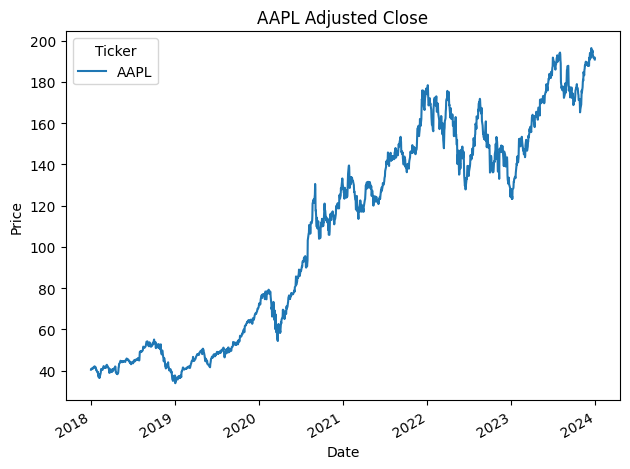

**Price plot:** trend/level only — we won't model prices directly for volatility.

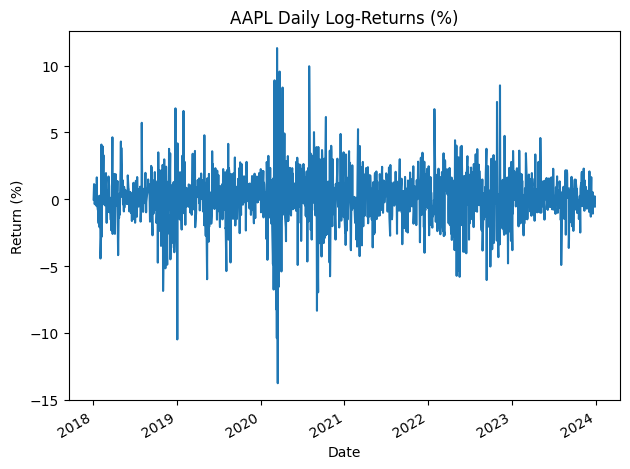

**Returns plot:** clusters of big/small moves indicate volatility clustering.

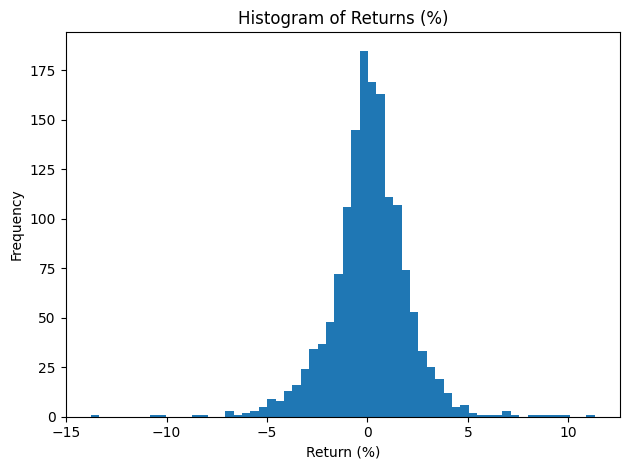

**Histogram:** peaked center with heavy tails → more extreme moves than a Normal distribution would suggest.

<Figure size 640x480 with 0 Axes>

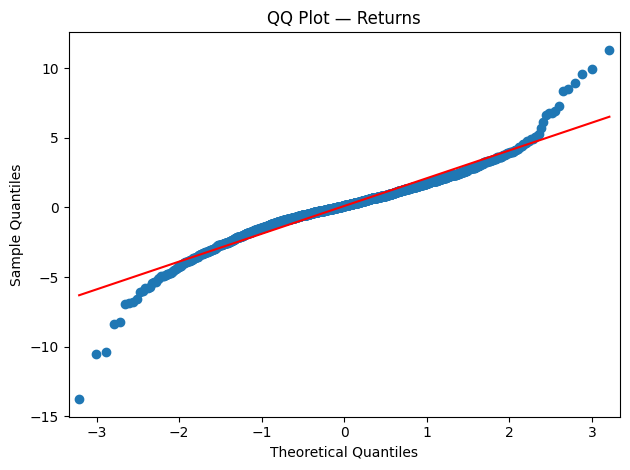

**QQ(returns):** curved tails away from the line suggest fat tails; Student-t innovations often fit better.

**ARCH LM p-value = 4.639e-51.**

**Interpretation:** volatility is time-varying (clustering present). **We should use GARCH-family models.**

**Now fitting candidate models (ARCH, GARCH, EGARCH, GJR) with AR(0)/AR(1) means and Normal/Student-t innovations; we will choose the lowest BIC (best fit vs complexity).**

**Top models by BIC (lower is better):**

,name,bic,aic
0,"AR(0)+GJR-GARCH(1,1,1)[t]",5955.418594,5923.507357
1,"AR(1)+GJR-GARCH(1,1,1)[t]",5960.681852,5923.456718
2,"AR(0)+GJR-GARCH(2,1,1)[t]",5962.737133,5925.507356
3,"AR(0)+GJR-GARCH(1,2,1)[t]",5962.737133,5925.507356
4,"AR(1)+GJR-GARCH(2,1,1)[t]",5967.999728,5925.456718
5,"AR(1)+GJR-GARCH(1,2,1)[t]",5967.999728,5925.456718
6,"AR(0)+GJR-GARCH(2,2,1)[t]",5970.055672,5927.507356
7,"AR(0)+GARCH(1,1)[t]",5971.200486,5944.607788
8,"AR(0)+EGARCH(1,1)[t]",5971.360177,5944.767479
9,"AR(1)+GJR-GARCH(2,2,1)[t]",5975.317604,5927.456718


**✅ Selected best model: AR(0)+GJR-GARCH(1,1,1)[t].**  **Reason:** lowest BIC (and strong AIC) → best trade-off between fit and parsimony.


Model summary (for reference):
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                         AAPL   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2955.75
Distribution:      Standardized Student's t   AIC:                           5923.51
Method:                  Maximum Likelihood   BIC:                           5955.42
                                              No. Observations:                 1508
Date:                      Fri, Oct 03 2025   Df Residuals:                     1507
Time:                              12:47:25   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-----------------------------------------------------

**Ljung–Box p-values on residuals (want > 0.05):**

,lb_stat,lb_pvalue
10,8.003130,0.628531
20,25.143451,0.195998


**Interpretation:** if p>0.05, residuals behave like white noise → **mean is modeled well.**

**Ljung–Box p-values on squared residuals (want > 0.05):**

,lb_stat,lb_pvalue
10,3.050288,0.980216
20,9.138685,0.981245


**Interpretation:** if p>0.05, no leftover ARCH effect → **volatility is modeled well.**

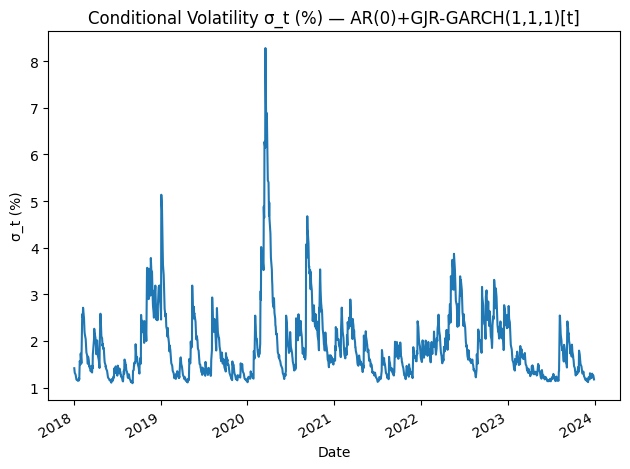

**σ_t plot:** shows changing risk over time; higher σ_t = more turbulent periods.

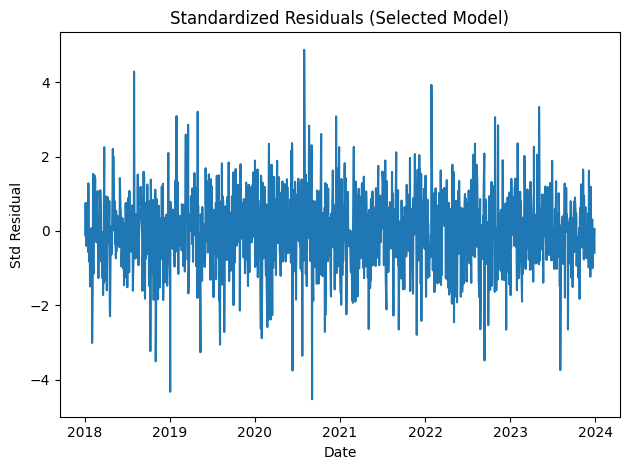

**Standardized residuals:** should look like pattern-free noise (no autocorrelation).

<Figure size 640x480 with 0 Axes>

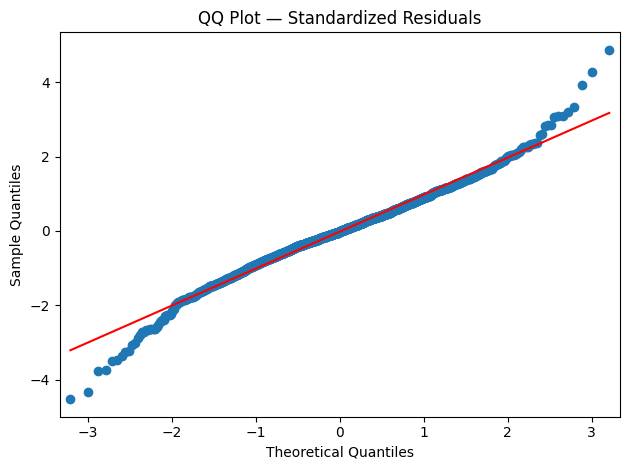

**QQ(std residuals):** closer to the straight line = better distributional fit.

**α = 0.031:** how strongly volatility reacts to fresh shocks (‘news’).

**β = 0.858:** how much yesterday’s volatility carries into today.

**α+β = 0.889:** overall persistence; **closer to 1 = shocks last longer**.

**Half-life ≈ 5.91 days:** time for a volatility shock to **halve** in size.

**Volatility forecast for the next 5 trading days (σ in %):**

**Day 1: σ ≈ 1.19%**

**Day 2: σ ≈ 1.22%**

**Day 3: σ ≈ 1.26%**

**Day 4: σ ≈ 1.29%**

**Day 5: σ ≈ 1.32%**

**Meaning:** σ is the expected daily ‘noise’ scale; higher σ implies wider expected daily swings.

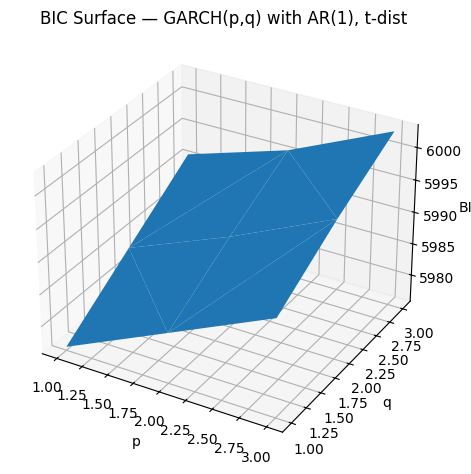

**3D BIC surface:** valleys show better (p,q) choices for plain GARCH under AR(1), t-innovations.

**Rolling backtest (last 20% of sample): we compare predicted variance with realized squared returns.**

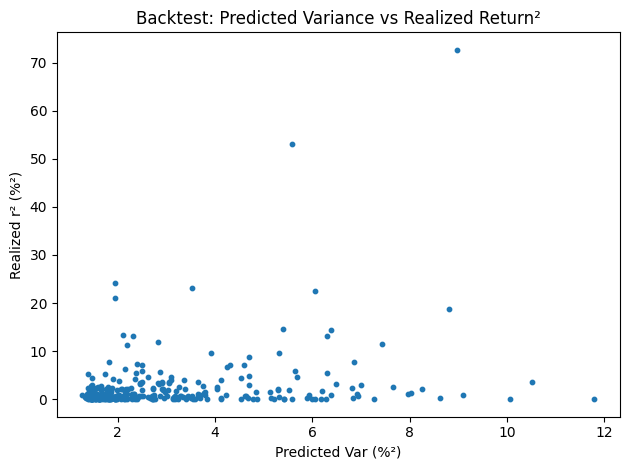

**Backtest QLIKE = 1.4874 (lower is better); Corr(pred, realized) = 0.274.**

**Interpretation:** lower QLIKE and higher correlation indicate the model’s variance forecasts track reality better.

**VaR backtest (Kupiec): checks if actual exceedances match the target rate.**

**Kupiec VaR test @ 95%:** breaches = **3/302**, LR = **15.007**, p-value = **0.0001**.

**Interpretation:** p-value > 0.05 → breach rate consistent with target; p-value < 0.05 → VaR is miscalibrated.**

**Kupiec VaR test @ 99%:** breaches = **1/302**, LR = **1.843**, p-value = **0.1746**.

**Interpretation:** p-value > 0.05 → breach rate consistent with target; p-value < 0.05 → VaR is miscalibrated.**

**=== Recommendations (Plain English) ===**

**Volatility shows noticeable persistence with some mean reversion.**

**Action:** scale risk down for a few days after shocks; monitor for normalization.

**Asymmetry captured: bad news raises volatility more than good news.**

**Action:** consider downside hedges (puts) or tighter stops around earnings/news.**

**Heavy tails: extreme moves happen more often than a Normal model predicts.**

**Action:** prefer Student-t-based VaR/ES or add stress scenarios; don’t rely only on Gaussian assumptions.**

**Operational:** refit/retune monthly or after major regime changes (vol spikes/crashes). Use σ forecasts for daily VaR/ES and for sizing before high-risk events (earnings, macro).

In [ ]:
# Volatility Modeling with Layman-Friendly Explanations + Graphs + Backtests + VaR (Kupiec)
# (fixed to ensure 1-D Series input for arch_model)
# -----------------------------------------------------------------------------------------
!pip install -q numpy pandas matplotlib statsmodels arch yfinance scipy

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from arch import arch_model
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy.stats import chi2, t as t_dist, norm
from IPython.display import display, Markdown

def md(text):
    display(Markdown(text))

# ---------- helpers to guarantee 1-D Series ----------
def to_series(x, name="series"):
    """
    Ensure x is a pandas Series (1-D), float, no NaNs, sorted by index.
    """
    if isinstance(x, pd.DataFrame):
        if x.shape[1] == 1:
            x = x.iloc[:, 0]
        else:
            # squeeze to first column with a warning note
            x = x.iloc[:, 0]
    elif not isinstance(x, pd.Series):
        x = pd.Series(x)
    x = pd.to_numeric(x, errors="coerce").dropna()
    x.name = x.name or name
    return x.sort_index()

# -------------------- DATA LOADER --------------------
def load_prices_or_simulate(ticker="AAPL", start="2018-01-01", end="2023-12-31"):
    try:
        import yfinance as yf
        df = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
        if df is not None and not df.empty:
            if "Adj Close" not in df.columns and "Close" in df.columns:
                df = df.rename(columns={"Close": "Adj Close"})
            md(f"**✅ Downloaded {ticker} prices from Yahoo Finance.**")
            return df[["Adj Close"]].dropna(), False
    except Exception:
        pass

    # Fallback simulation
    days = pd.bdate_range(start=start, end=end)
    n = len(days)
    omega, alpha, beta = 0.000002, 0.10, 0.85
    eps = np.zeros(n); var = np.zeros(n)
    var[0] = omega / (1 - alpha - beta)
    for i in range(1, n):
        eps[i-1] = np.sqrt(var[i-1]) * np.random.standard_t(df=6) / np.sqrt(6/(6-2))
        var[i]   = omega + alpha*(eps[i-1]**2) + beta*var[i-1]
    eps[-1] = np.sqrt(var[-1]) * np.random.standard_t(df=6) / np.sqrt(6/(6-2))
    prices = 100*np.exp(np.cumsum(eps))
    md("**⚠️ Using simulated data (Yahoo download failed).**")
    return pd.DataFrame({"Adj Close": prices}, index=days), True

# -------------------- SPEC BUILDER --------------------
def build_specs(r):
    # r must be 1-D Series already
    mean_options = [("AR(0)", dict(mean="Constant")),
                    ("AR(1)", dict(mean="AR", lags=1))]
    dists = ["normal", "t"]
    specs=[]
    for mname,mkw in mean_options:
        # ARCH
        for p in [1,2]:
            for dist in dists:
                specs.append((f"{mname}+ARCH({p})[{dist}]",
                              arch_model(r, vol="ARCH", p=p, dist=dist, **mkw)))
        # GARCH
        for p in [1,2]:
            for q in [1,2]:
                for dist in dists:
                    specs.append((f"{mname}+GARCH({p},{q})[{dist}]",
                                  arch_model(r, vol="GARCH", p=p, q=q, dist=dist, **mkw)))
        # EGARCH
        for p in [1,2]:
            for q in [1,2]:
                for dist in dists:
                    specs.append((f"{mname}+EGARCH({p},{q})[{dist}]",
                                  arch_model(r, vol="EGARCH", p=p, q=q, dist=dist, **mkw)))
        # GJR-GARCH (o=1 asymmetry)
        for p in [1,2]:
            for q in [1,2]:
                for dist in dists:
                    specs.append((f"{mname}+GJR-GARCH({p},{q},1)[{dist}]",
                                  arch_model(r, vol="GARCH", p=p, q=q, o=1, dist=dist, **mkw)))
    return specs

# -------------------- FIT / INTERP HELPERS --------------------
def fit_safely(m):
    try:
        return m.fit(disp="off")
    except Exception:
        return None

def persistence_and_halflife(res):
    par = res.params
    a = par.filter(like="alpha").sum() if any("alpha" in k for k in par.index) else np.nan
    b = par.filter(like="beta").sum()  if any("beta"  in k for k in par.index) else np.nan
    persistence = np.nan; half_life = np.nan
    if np.isfinite(a) and np.isfinite(b):
        persistence = a + b
        if 0 < persistence < 1:
            half_life = np.log(0.5) / np.log(persistence)
    return a, b, persistence, half_life

def garch_bic_surface(r):
    r = to_series(r, "returns")  # ensure 1-D
    P, Q = [1,2,3], [1,2,3]
    S = np.full((len(P), len(Q)), np.nan)
    for i,p in enumerate(P):
        for j,q in enumerate(Q):
            try:
                res = arch_model(r, mean="AR", lags=1, vol="GARCH", p=p, q=q, dist="t").fit(disp="off")
                S[i,j] = res.bic
            except Exception:
                pass
    return np.array(P), np.array(Q), S

def recreate_model_like(name, series):
    """Recreate the selected spec from its name string (for rolling backtest)."""
    series = to_series(series, "returns")  # ensure 1-D
    use_ar1 = "AR(1)" in name
    mean_kw = dict(mean="AR", lags=1) if use_ar1 else dict(mean="Constant")

    if "EGARCH" in name:
        p = 2 if "(2," in name else 1
        q = 2 if ",2)" in name else 1
        vol_kw = dict(vol="EGARCH", p=p, q=q)
    elif "GJR-GARCH" in name:
        p = 2 if "(2," in name else 1
        q = 2 if ",2," in name else 1
        vol_kw = dict(vol="GARCH", p=p, q=q, o=1)
    elif "GARCH" in name and "EGARCH" not in name and "GJR" not in name:
        p = 2 if "GARCH(2," in name else 1
        q = 2 if ",2)" in name else 1
        vol_kw = dict(vol="GARCH", p=p, q=q)
    else:
        p = 2 if "ARCH(2)" in name else 1
        vol_kw = dict(vol="ARCH", p=p)

    dist = "t" if "[t]" in name.lower() else "normal"
    return arch_model(series, dist=dist, **mean_kw, **vol_kw), dist

# -------------------- MAIN --------------------
def main(ticker="AAPL", start="2018-01-01", end="2023-12-31", horizon=5, backtest_frac=0.2, seed=42):
    np.random.seed(seed)

    # 1) Data & returns
    prices, is_sim = load_prices_or_simulate(ticker, start, end)
    prices = prices[["Adj Close"]].copy()
    prices = prices.dropna().sort_index()
    returns = 100*np.log(prices["Adj Close"]).diff()
    returns = to_series(returns, "r_pct")

    md("**We computed daily log-returns in percent because returns are closer to stationary (better for modeling) than prices.**")

    # PLOTS: price & returns & hist & QQ
    plt.figure(); prices["Adj Close"].plot(title=f"{ticker} Adjusted Close" + (" [SIMULATED]" if is_sim else "")); plt.xlabel("Date"); plt.ylabel("Price"); plt.tight_layout(); plt.show()
    md("**Price plot:** trend/level only — we won't model prices directly for volatility.")

    plt.figure(); returns.plot(title=f"{ticker} Daily Log-Returns (%)" + (" [SIMULATED]" if is_sim else "")); plt.xlabel("Date"); plt.ylabel("Return (%)"); plt.tight_layout(); plt.show()
    md("**Returns plot:** clusters of big/small moves indicate volatility clustering.")

    plt.figure(); plt.hist(returns.values, bins=60); plt.title("Histogram of Returns (%)"); plt.xlabel("Return (%)"); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()
    md("**Histogram:** peaked center with heavy tails → more extreme moves than a Normal distribution would suggest.")

    plt.figure(); qqplot(returns.values, line="s"); plt.title("QQ Plot — Returns"); plt.tight_layout(); plt.show()
    md("**QQ(returns):** curved tails away from the line suggest fat tails; Student-t innovations often fit better.")

    # 2) ARCH LM test
    stat, pval, _, _ = het_arch(returns)
    md(f"**ARCH LM p-value = {pval:.4g}.**")
    if pval < 0.05:
        md("**Interpretation:** volatility is time-varying (clustering present). **We should use GARCH-family models.**")
    else:
        md("**Interpretation:** little evidence of volatility clustering; **a constant-variance model might suffice.**")

    # 3) Fit candidates & rank
    md("**Now fitting candidate models (ARCH, GARCH, EGARCH, GJR) with AR(0)/AR(1) means and Normal/Student-t innovations; we will choose the lowest BIC (best fit vs complexity).**")
    # Ensure 1-D series passed to arch_model in all specs
    r = to_series(returns, "returns")
    rows=[]
    for name, model in build_specs(r):
        res = fit_safely(model)
        if res is not None and np.isfinite(res.bic) and np.isfinite(res.aic):
            rows.append({"name": name, "bic": res.bic, "aic": res.aic, "res": res})
    if not rows:
        raise RuntimeError("All model fits failed. Try reducing the grid or changing dates.")
    df = pd.DataFrame(rows).sort_values(["bic","aic"]).reset_index(drop=True)

    md("**Top models by BIC (lower is better):**")
    display(df[["name","bic","aic"]].head(10))

    best = df.iloc[0]
    best_name, best_res = best["name"], best["res"]
    md(f"**✅ Selected best model: {best_name}.**  **Reason:** lowest BIC (and strong AIC) → best trade-off between fit and parsimony.")

    # Optional: raw summary for reference
    print("\nModel summary (for reference):")
    print(best_res.summary())

    # 4) Diagnostics (residual checks)
    std_resid = to_series(best_res.std_resid, "std_resid")
    lb_res = acorr_ljungbox(std_resid, lags=[10,20], return_df=True)
    lb_sq  = acorr_ljungbox(std_resid**2, lags=[10,20], return_df=True)

    md("**Ljung–Box p-values on residuals (want > 0.05):**")
    display(lb_res)
    md("**Interpretation:** if p>0.05, residuals behave like white noise → **mean is modeled well.**")

    md("**Ljung–Box p-values on squared residuals (want > 0.05):**")
    display(lb_sq)
    md("**Interpretation:** if p>0.05, no leftover ARCH effect → **volatility is modeled well.**")

    # PLOTS: Conditional vol & residuals QQ
    plt.figure(); best_res.conditional_volatility.plot(title=f"Conditional Volatility σ_t (%) — {best_name}"); plt.xlabel("Date"); plt.ylabel("σ_t (%)"); plt.tight_layout(); plt.show()
    md("**σ_t plot:** shows changing risk over time; higher σ_t = more turbulent periods.")

    plt.figure(); plt.plot(std_resid.index, std_resid.values); plt.title("Standardized Residuals (Selected Model)"); plt.xlabel("Date"); plt.ylabel("Std Residual"); plt.tight_layout(); plt.show()
    md("**Standardized residuals:** should look like pattern-free noise (no autocorrelation).")

    plt.figure(); qqplot(std_resid.values, line="s"); plt.title("QQ Plot — Standardized Residuals"); plt.tight_layout(); plt.show()
    md("**QQ(std residuals):** closer to the straight line = better distributional fit.")

    # 5) Coefficient interpretation
    a, b, persistence, half_life = persistence_and_halflife(best_res)
    if np.isfinite(a): md(f"**α = {a:.3f}:** how strongly volatility reacts to fresh shocks (‘news’).")
    if np.isfinite(b): md(f"**β = {b:.3f}:** how much yesterday’s volatility carries into today.")
    if np.isfinite(persistence): md(f"**α+β = {persistence:.3f}:** overall persistence; **closer to 1 = shocks last longer**.")
    if np.isfinite(half_life):  md(f"**Half-life ≈ {half_life:.2f} days:** time for a volatility shock to **halve** in size.")

    # 6) Volatility forecast next N days
    fc = best_res.forecast(horizon=horizon)
    md(f"**Volatility forecast for the next {horizon} trading days (σ in %):**")
    for i, var in enumerate(fc.variance.iloc[-1].values, start=1):
        md(f"**Day {i}: σ ≈ {np.sqrt(var):.2f}%**")
    md("**Meaning:** σ is the expected daily ‘noise’ scale; higher σ implies wider expected daily swings.")

    # 7) 3D BIC surface (visual order choice)
    P, Q, S = garch_bic_surface(r)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    PP, QQ = np.meshgrid(P, Q, indexing="ij")
    mask = ~np.isnan(S)
    ax.plot_trisurf(PP[mask], QQ[mask], S[mask])
    ax.set_title("BIC Surface — GARCH(p,q) with AR(1), t-dist")
    ax.set_xlabel("p"); ax.set_ylabel("q"); ax.set_zlabel("BIC")
    plt.tight_layout(); plt.show()
    md("**3D BIC surface:** valleys show better (p,q) choices for plain GARCH under AR(1), t-innovations.")

    # 8) Rolling 1-step variance backtest on last 20%
    md("**Rolling backtest (last 20% of sample): we compare predicted variance with realized squared returns.**")
    split_idx = int((1 - backtest_frac) * len(r))
    train_r, test_r = r.iloc[:split_idx], r.iloc[split_idx:]

    preds, realized = [], []
    hist = to_series(train_r, "returns_hist")
    if len(test_r) > 20:
        for t in test_r.index:
            m, dist_name = recreate_model_like(best_name, hist)
            rs = m.fit(disp="off")
            f  = rs.forecast(horizon=1)
            preds.append(float(f.variance.iloc[-1,0]))    # predicted var (%^2)
            realized.append(float(test_r.loc[t]**2))      # realized r^2 (%^2)
            # expand history
            hist = to_series(pd.concat([hist, pd.Series(test_r.loc[t], index=[t])]), "returns_hist")

        back = pd.DataFrame({"pred_var": preds, "realized_sq": realized}, index=test_r.index)

        # QLIKE (lower better) and corr
        eps = 1e-12
        qlike = np.mean(back["realized_sq"]/(back["pred_var"]+eps) - np.log(back["realized_sq"]+eps) + np.log(back["pred_var"]+eps) - 1)
        corr  = back.corr().iloc[0,1]

        plt.figure(); plt.scatter(back["pred_var"].values, back["realized_sq"].values, s=10)
        plt.title("Backtest: Predicted Variance vs Realized Return²")
        plt.xlabel("Predicted Var (%²)"); plt.ylabel("Realized r² (%²)")
        plt.tight_layout(); plt.show()

        md(f"**Backtest QLIKE = {qlike:.4f} (lower is better); Corr(pred, realized) = {corr:.3f}.**")
        md("**Interpretation:** lower QLIKE and higher correlation indicate the model’s variance forecasts track reality better.")
    else:
        md("**[Info] Backtest skipped (test window too small).**")
        back, dist_name = None, ("t" if "[t]" in best_name.lower() else "normal")

    # 9) VaR hit-rate (Kupiec) on backtest window
    if 'back' in locals() and back is not None:
        md("**VaR backtest (Kupiec): checks if actual exceedances match the target rate.**")
        sigma = np.sqrt(back["pred_var"].values)  # % units
        r_real = test_r.values                    # % returns

        def kupiec_test(alpha, dist_key, sig, realized):
            if dist_key == "t":
                nu = 8
                if "nu" in best_res.params.index:
                    try: nu = float(best_res.params["nu"])
                    except: pass
                q = t_dist.ppf(1-alpha, df=nu)
            else:
                q = norm.ppf(1-alpha)
            var_line = q * sig                     # VaR threshold in % returns (mean≈0)
            breaches = (realized < var_line).astype(int)  # left-tail
            x = breaches.sum(); T = len(breaches); p = 1 - alpha
            phat = x / T if T > 0 else 0.0
            if phat in (0,1) or T == 0:
                return x, T, 0.0, 1.0
            LR = -2 * ((T-x)*np.log(1-p) + x*np.log(p) - (T-x)*np.log(1-phat) - x*np.log(phat))
            pval = 1 - chi2.cdf(LR, df=1)
            return x, T, LR, pval

        dist_key = "t" if "[t]" in best_name.lower() else "normal"
        for conf in (0.95, 0.99):
            x, T, LR, pval = kupiec_test(conf, dist_key, sigma, r_real)
            md(f"**Kupiec VaR test @ {int(conf*100)}%:** breaches = **{x}/{T}**, LR = **{LR:.3f}**, p-value = **{pval:.4f}**.")
            md("**Interpretation:** p-value > 0.05 → breach rate consistent with target; p-value < 0.05 → VaR is miscalibrated.**")

    # 10) Final recommendations
    md("**=== Recommendations (Plain English) ===**")
    heavy_tails = ("t]" in best_name.lower()) or ("[t]" in best_name.lower()) or (" t" in best_name.lower())
    if np.isfinite(persistence):
        if persistence > 0.97:
            md("**Volatility is extremely persistent: once markets get jumpy, they tend to stay jumpy for days.**")
            md("**Action:** use conservative leverage and wider risk buffers; expect prolonged turbulence.")
        elif persistence > 0.90:
            md("**Volatility is highly persistent: after a shock, elevated risk lingers.**")
            md("**Action:** adjust position sizing to account for sustained higher σ; avoid overtrading in choppy regimes.")
        elif persistence > 0.80:
            md("**Volatility shows noticeable persistence with some mean reversion.**")
            md("**Action:** scale risk down for a few days after shocks; monitor for normalization.")
        else:
            md("**Volatility mean-reverts relatively quickly.**")
            md("**Action:** shocks fade fast; simple risk rules may suffice, but keep an eye on regime shifts.")
    if "EGARCH" in best_name or "GJR" in best_name:
        md("**Asymmetry captured: bad news raises volatility more than good news.**")
        md("**Action:** consider downside hedges (puts) or tighter stops around earnings/news.**")
    if heavy_tails:
        md("**Heavy tails: extreme moves happen more often than a Normal model predicts.**")
        md("**Action:** prefer Student-t-based VaR/ES or add stress scenarios; don’t rely only on Gaussian assumptions.**")
    md("**Operational:** refit/retune monthly or after major regime changes (vol spikes/crashes). Use σ forecasts for daily VaR/ES and for sizing before high-risk events (earnings, macro).")

# -------------------- RUN --------------------
main(ticker="AAPL", start="2018-01-01", end="2023-12-31", horizon=5, backtest_frac=0.2, seed=42)


**✅ Downloaded MSFT prices from Yahoo Finance.**

**We computed daily log-returns in percent because returns are closer to stationary (better for modeling) than prices.**

<Figure size 640x480 with 0 Axes>

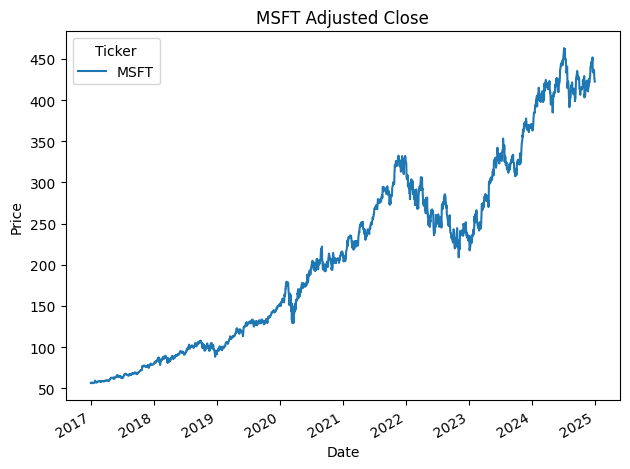

**Price plot:** trend/level only — we won't model prices directly for volatility.

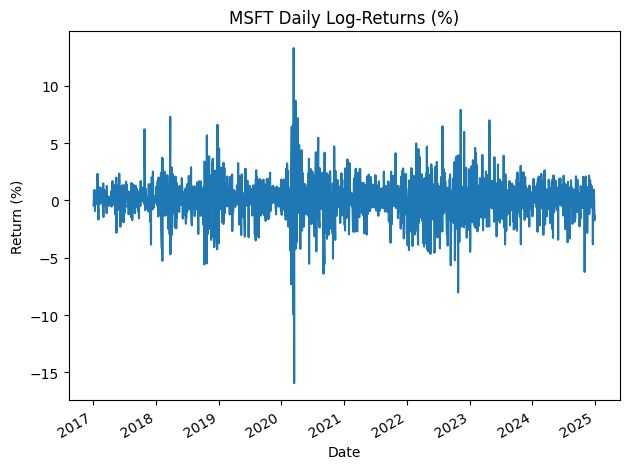

**Returns plot:** clusters of big/small moves indicate volatility clustering.

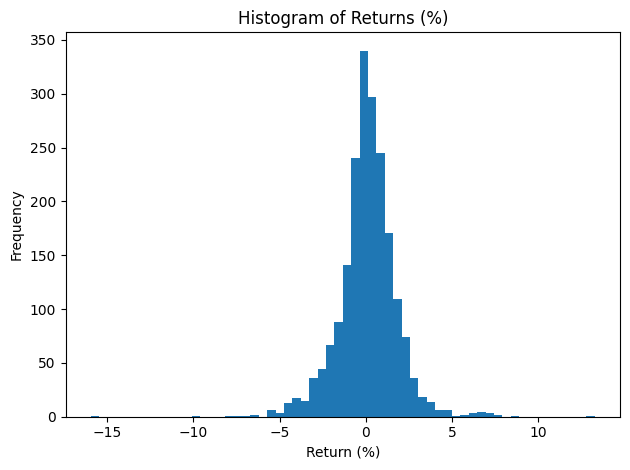

**Histogram:** peaked center with heavy tails → more extreme moves than a Normal distribution would suggest.

<Figure size 640x480 with 0 Axes>

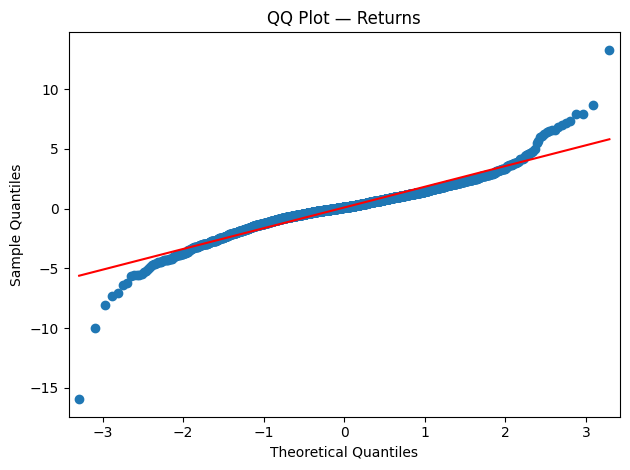

**QQ(returns):** curved tails away from the line suggest fat tails; Student-t innovations often fit better.

**ARCH LM p-value = 1.233e-120.**

**Interpretation:** volatility is time-varying (clustering present). **We should use GARCH-family models.**

**Now fitting candidate models (ARCH, GARCH, EGARCH, GJR) with AR(0)/AR(1) means and Normal/Student-t innovations; we will choose the lowest BIC (best fit vs complexity).**

**Top models by BIC (lower is better):**

,name,bic,aic
0,"AR(1)+GJR-GARCH(1,1,1)[t]",7247.704540,7208.466793
1,"AR(1)+EGARCH(1,1)[t]",7249.009614,7215.377259
2,"AR(0)+GJR-GARCH(1,1,1)[t]",7253.723279,7220.087939
3,"AR(1)+GJR-GARCH(1,2,1)[t]",7254.623939,7209.780800
4,"AR(1)+GJR-GARCH(2,1,1)[t]",7255.309932,7210.466793
5,"AR(1)+GARCH(1,1)[t]",7255.595718,7221.963364
6,"AR(0)+EGARCH(1,1)[t]",7256.019189,7227.989739
7,"AR(1)+EGARCH(2,1)[t]",7256.459636,7217.221889
8,"AR(1)+EGARCH(1,2)[t]",7256.516256,7217.278509
9,"AR(0)+GJR-GARCH(1,2,1)[t]",7260.632235,7221.391005


**✅ Selected best model: AR(1)+GJR-GARCH(1,1,1)[t].**  **Reason:** lowest BIC (and strong AIC) → best trade-off between fit and parsimony.


Model summary (for reference):
                            AR - GJR-GARCH Model Results                            
Dep. Variable:                         MSFT   R-squared:                       0.020
Mean Model:                              AR   Adj. R-squared:                  0.020
Vol Model:                        GJR-GARCH   Log-Likelihood:               -3597.23
Distribution:      Standardized Student's t   AIC:                           7208.47
Method:                  Maximum Likelihood   BIC:                           7247.70
                                              No. Observations:                 2009
Date:                      Fri, Oct 03 2025   Df Residuals:                     2007
Time:                              12:51:04   Df Model:                            2
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------

**Ljung–Box p-values on residuals (want > 0.05):**

,lb_stat,lb_pvalue
10,10.801687,0.373176
20,20.532757,0.425077


**Interpretation:** if p>0.05, residuals behave like white noise → **mean is modeled well.**

**Ljung–Box p-values on squared residuals (want > 0.05):**

,lb_stat,lb_pvalue
10,5.832769,0.829112
20,12.781422,0.886564


**Interpretation:** if p>0.05, no leftover ARCH effect → **volatility is modeled well.**

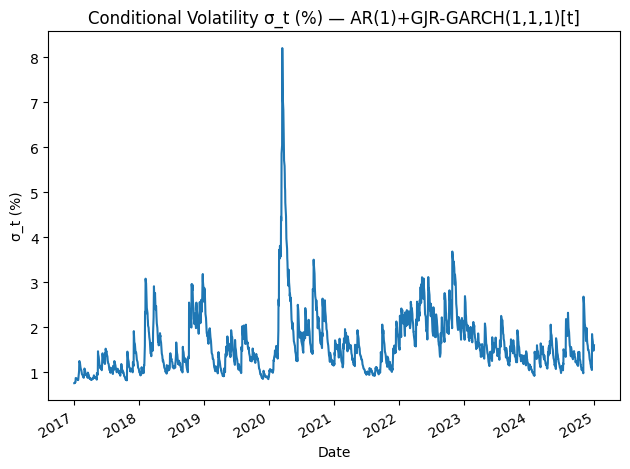

**σ_t plot:** shows changing risk over time; higher σ_t = more turbulent periods.

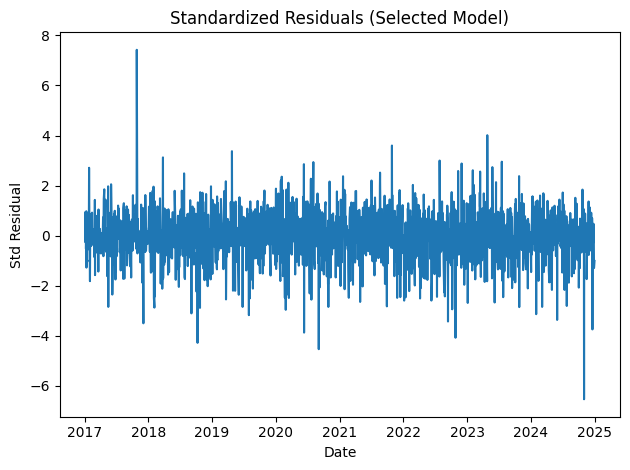

**Standardized residuals:** should look like pattern-free noise (no autocorrelation).

<Figure size 640x480 with 0 Axes>

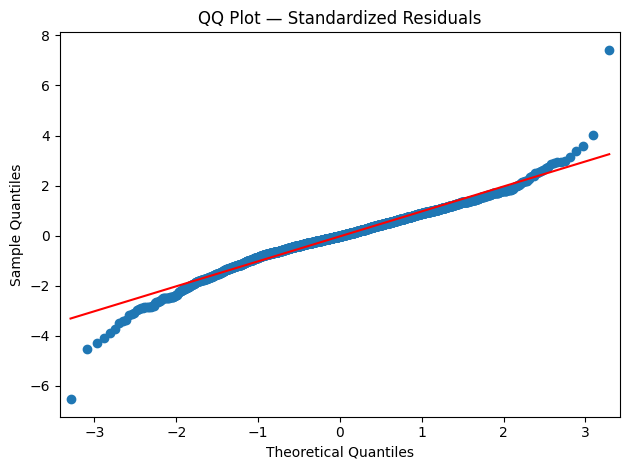

**QQ(std residuals):** closer to the straight line = better distributional fit.

**α = 0.040:** how strongly volatility reacts to fresh shocks (‘news’).

**β = 0.884:** how much yesterday’s volatility carries into today.

**α+β = 0.924:** overall persistence; **closer to 1 = shocks last longer**.

**Half-life ≈ 8.77 days:** time for a volatility shock to **halve** in size.

**Volatility forecast for the next 5 trading days (σ in %):**

**Day 1: σ ≈ 1.65%**

**Day 2: σ ≈ 1.66%**

**Day 3: σ ≈ 1.66%**

**Day 4: σ ≈ 1.66%**

**Day 5: σ ≈ 1.66%**

**Meaning:** σ is the expected daily ‘noise’ scale; higher σ implies wider expected daily swings.

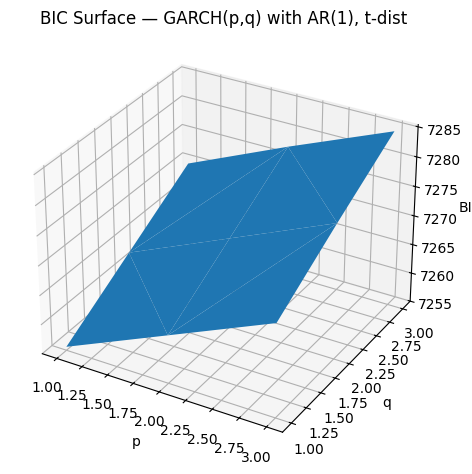

**3D BIC surface:** valleys show better (p,q) choices for plain GARCH under AR(1), t-innovations.

**Rolling backtest (last 20% of sample): we compare predicted variance with realized squared returns.**

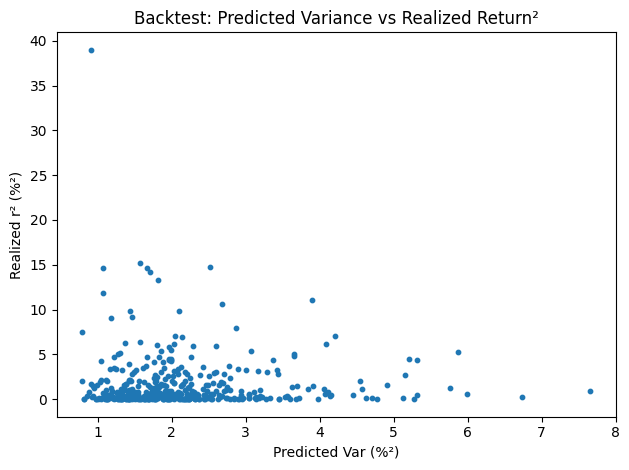

**Backtest QLIKE = 1.5703 (lower is better); Corr(pred, realized) = -0.038.**

**Interpretation:** lower QLIKE and higher correlation indicate the model’s variance forecasts track reality better.

**VaR backtest (Kupiec): checks if actual exceedances match the target rate.**

**Kupiec VaR test @ 95%:** breaches = **14/402**, LR = **2.170**, p-value = **0.1407**.

**Interpretation:** p-value > 0.05 → breach rate consistent with target; p-value < 0.05 → VaR is miscalibrated.**

**Kupiec VaR test @ 99%:** breaches = **3/402**, LR = **0.287**, p-value = **0.5924**.

**Interpretation:** p-value > 0.05 → breach rate consistent with target; p-value < 0.05 → VaR is miscalibrated.**

**=== Recommendations (Plain English) ===**

**Volatility is highly persistent: after a shock, elevated risk lingers.**

**Action:** adjust position sizing to account for sustained higher σ; avoid overtrading in choppy regimes.

**Asymmetry captured: bad news raises volatility more than good news.**

**Action:** consider downside hedges (puts) or tighter stops around earnings/news.**

**Heavy tails: extreme moves happen more often than a Normal model predicts.**

**Action:** prefer Student-t-based VaR/ES or add stress scenarios; don’t rely only on Gaussian assumptions.**

**Operational:** refit/retune monthly or after major regime changes (vol spikes/crashes). Use σ forecasts for daily VaR/ES and for sizing before high-risk events (earnings, macro).

In [ ]:
# Volatility Modeling with Layman-Friendly Explanations + Graphs + Backtests + VaR (Kupiec)
# (fixed to ensure 1-D Series input for arch_model)
# -----------------------------------------------------------------------------------------
!pip install -q numpy pandas matplotlib statsmodels arch yfinance scipy

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.graphics.gofplots import qqplot
from arch import arch_model
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy.stats import chi2, t as t_dist, norm
from IPython.display import display, Markdown

def md(text):
    display(Markdown(text))

# ---------- helpers to guarantee 1-D Series ----------
def to_series(x, name="series"):
    """
    Ensure x is a pandas Series (1-D), float, no NaNs, sorted by index.
    """
    if isinstance(x, pd.DataFrame):
        if x.shape[1] == 1:
            x = x.iloc[:, 0]
        else:
            # squeeze to first column with a warning note
            x = x.iloc[:, 0]
    elif not isinstance(x, pd.Series):
        x = pd.Series(x)
    x = pd.to_numeric(x, errors="coerce").dropna()
    x.name = x.name or name
    return x.sort_index()

# -------------------- DATA LOADER --------------------
def load_prices_or_simulate(ticker="AAPL", start="2018-01-01", end="2023-12-31"):
    try:
        import yfinance as yf
        df = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
        if df is not None and not df.empty:
            if "Adj Close" not in df.columns and "Close" in df.columns:
                df = df.rename(columns={"Close": "Adj Close"})
            md(f"**✅ Downloaded {ticker} prices from Yahoo Finance.**")
            return df[["Adj Close"]].dropna(), False
    except Exception:
        pass

    # Fallback simulation
    days = pd.bdate_range(start=start, end=end)
    n = len(days)
    omega, alpha, beta = 0.000002, 0.10, 0.85
    eps = np.zeros(n); var = np.zeros(n)
    var[0] = omega / (1 - alpha - beta)
    for i in range(1, n):
        eps[i-1] = np.sqrt(var[i-1]) * np.random.standard_t(df=6) / np.sqrt(6/(6-2))
        var[i]   = omega + alpha*(eps[i-1]**2) + beta*var[i-1]
    eps[-1] = np.sqrt(var[-1]) * np.random.standard_t(df=6) / np.sqrt(6/(6-2))
    prices = 100*np.exp(np.cumsum(eps))
    md("**⚠️ Using simulated data (Yahoo download failed).**")
    return pd.DataFrame({"Adj Close": prices}, index=days), True

# -------------------- SPEC BUILDER --------------------
def build_specs(r):
    # r must be 1-D Series already
    mean_options = [("AR(0)", dict(mean="Constant")),
                    ("AR(1)", dict(mean="AR", lags=1))]
    dists = ["normal", "t"]
    specs=[]
    for mname,mkw in mean_options:
        # ARCH
        for p in [1,2]:
            for dist in dists:
                specs.append((f"{mname}+ARCH({p})[{dist}]",
                              arch_model(r, vol="ARCH", p=p, dist=dist, **mkw)))
        # GARCH
        for p in [1,2]:
            for q in [1,2]:
                for dist in dists:
                    specs.append((f"{mname}+GARCH({p},{q})[{dist}]",
                                  arch_model(r, vol="GARCH", p=p, q=q, dist=dist, **mkw)))
        # EGARCH
        for p in [1,2]:
            for q in [1,2]:
                for dist in dists:
                    specs.append((f"{mname}+EGARCH({p},{q})[{dist}]",
                                  arch_model(r, vol="EGARCH", p=p, q=q, dist=dist, **mkw)))
        # GJR-GARCH (o=1 asymmetry)
        for p in [1,2]:
            for q in [1,2]:
                for dist in dists:
                    specs.append((f"{mname}+GJR-GARCH({p},{q},1)[{dist}]",
                                  arch_model(r, vol="GARCH", p=p, q=q, o=1, dist=dist, **mkw)))
    return specs

# -------------------- FIT / INTERP HELPERS --------------------
def fit_safely(m):
    try:
        return m.fit(disp="off")
    except Exception:
        return None

def persistence_and_halflife(res):
    par = res.params
    a = par.filter(like="alpha").sum() if any("alpha" in k for k in par.index) else np.nan
    b = par.filter(like="beta").sum()  if any("beta"  in k for k in par.index) else np.nan
    persistence = np.nan; half_life = np.nan
    if np.isfinite(a) and np.isfinite(b):
        persistence = a + b
        if 0 < persistence < 1:
            half_life = np.log(0.5) / np.log(persistence)
    return a, b, persistence, half_life

def garch_bic_surface(r):
    r = to_series(r, "returns")  # ensure 1-D
    P, Q = [1,2,3], [1,2,3]
    S = np.full((len(P), len(Q)), np.nan)
    for i,p in enumerate(P):
        for j,q in enumerate(Q):
            try:
                res = arch_model(r, mean="AR", lags=1, vol="GARCH", p=p, q=q, dist="t").fit(disp="off")
                S[i,j] = res.bic
            except Exception:
                pass
    return np.array(P), np.array(Q), S

def recreate_model_like(name, series):
    """Recreate the selected spec from its name string (for rolling backtest)."""
    series = to_series(series, "returns")  # ensure 1-D
    use_ar1 = "AR(1)" in name
    mean_kw = dict(mean="AR", lags=1) if use_ar1 else dict(mean="Constant")

    if "EGARCH" in name:
        p = 2 if "(2," in name else 1
        q = 2 if ",2)" in name else 1
        vol_kw = dict(vol="EGARCH", p=p, q=q)
    elif "GJR-GARCH" in name:
        p = 2 if "(2," in name else 1
        q = 2 if ",2," in name else 1
        vol_kw = dict(vol="GARCH", p=p, q=q, o=1)
    elif "GARCH" in name and "EGARCH" not in name and "GJR" not in name:
        p = 2 if "GARCH(2," in name else 1
        q = 2 if ",2)" in name else 1
        vol_kw = dict(vol="GARCH", p=p, q=q)
    else:
        p = 2 if "ARCH(2)" in name else 1
        vol_kw = dict(vol="ARCH", p=p)

    dist = "t" if "[t]" in name.lower() else "normal"
    return arch_model(series, dist=dist, **mean_kw, **vol_kw), dist

# -------------------- MAIN --------------------
def main(ticker="AAPL", start="2018-01-01", end="2023-12-31", horizon=5, backtest_frac=0.2, seed=42):
    np.random.seed(seed)

    # 1) Data & returns
    prices, is_sim = load_prices_or_simulate(ticker, start, end)
    prices = prices[["Adj Close"]].copy()
    prices = prices.dropna().sort_index()
    returns = 100*np.log(prices["Adj Close"]).diff()
    returns = to_series(returns, "r_pct")

    md("**We computed daily log-returns in percent because returns are closer to stationary (better for modeling) than prices.**")

    # PLOTS: price & returns & hist & QQ
    plt.figure(); prices["Adj Close"].plot(title=f"{ticker} Adjusted Close" + (" [SIMULATED]" if is_sim else "")); plt.xlabel("Date"); plt.ylabel("Price"); plt.tight_layout(); plt.show()
    md("**Price plot:** trend/level only — we won't model prices directly for volatility.")

    plt.figure(); returns.plot(title=f"{ticker} Daily Log-Returns (%)" + (" [SIMULATED]" if is_sim else "")); plt.xlabel("Date"); plt.ylabel("Return (%)"); plt.tight_layout(); plt.show()
    md("**Returns plot:** clusters of big/small moves indicate volatility clustering.")

    plt.figure(); plt.hist(returns.values, bins=60); plt.title("Histogram of Returns (%)"); plt.xlabel("Return (%)"); plt.ylabel("Frequency"); plt.tight_layout(); plt.show()
    md("**Histogram:** peaked center with heavy tails → more extreme moves than a Normal distribution would suggest.")

    plt.figure(); qqplot(returns.values, line="s"); plt.title("QQ Plot — Returns"); plt.tight_layout(); plt.show()
    md("**QQ(returns):** curved tails away from the line suggest fat tails; Student-t innovations often fit better.")

    # 2) ARCH LM test
    stat, pval, _, _ = het_arch(returns)
    md(f"**ARCH LM p-value = {pval:.4g}.**")
    if pval < 0.05:
        md("**Interpretation:** volatility is time-varying (clustering present). **We should use GARCH-family models.**")
    else:
        md("**Interpretation:** little evidence of volatility clustering; **a constant-variance model might suffice.**")

    # 3) Fit candidates & rank
    md("**Now fitting candidate models (ARCH, GARCH, EGARCH, GJR) with AR(0)/AR(1) means and Normal/Student-t innovations; we will choose the lowest BIC (best fit vs complexity).**")
    # Ensure 1-D series passed to arch_model in all specs
    r = to_series(returns, "returns")
    rows=[]
    for name, model in build_specs(r):
        res = fit_safely(model)
        if res is not None and np.isfinite(res.bic) and np.isfinite(res.aic):
            rows.append({"name": name, "bic": res.bic, "aic": res.aic, "res": res})
    if not rows:
        raise RuntimeError("All model fits failed. Try reducing the grid or changing dates.")
    df = pd.DataFrame(rows).sort_values(["bic","aic"]).reset_index(drop=True)

    md("**Top models by BIC (lower is better):**")
    display(df[["name","bic","aic"]].head(10))

    best = df.iloc[0]
    best_name, best_res = best["name"], best["res"]
    md(f"**✅ Selected best model: {best_name}.**  **Reason:** lowest BIC (and strong AIC) → best trade-off between fit and parsimony.")

    # Optional: raw summary for reference
    print("\nModel summary (for reference):")
    print(best_res.summary())

    # 4) Diagnostics (residual checks)
    std_resid = to_series(best_res.std_resid, "std_resid")
    lb_res = acorr_ljungbox(std_resid, lags=[10,20], return_df=True)
    lb_sq  = acorr_ljungbox(std_resid**2, lags=[10,20], return_df=True)

    md("**Ljung–Box p-values on residuals (want > 0.05):**")
    display(lb_res)
    md("**Interpretation:** if p>0.05, residuals behave like white noise → **mean is modeled well.**")

    md("**Ljung–Box p-values on squared residuals (want > 0.05):**")
    display(lb_sq)
    md("**Interpretation:** if p>0.05, no leftover ARCH effect → **volatility is modeled well.**")

    # PLOTS: Conditional vol & residuals QQ
    plt.figure(); best_res.conditional_volatility.plot(title=f"Conditional Volatility σ_t (%) — {best_name}"); plt.xlabel("Date"); plt.ylabel("σ_t (%)"); plt.tight_layout(); plt.show()
    md("**σ_t plot:** shows changing risk over time; higher σ_t = more turbulent periods.")

    plt.figure(); plt.plot(std_resid.index, std_resid.values); plt.title("Standardized Residuals (Selected Model)"); plt.xlabel("Date"); plt.ylabel("Std Residual"); plt.tight_layout(); plt.show()
    md("**Standardized residuals:** should look like pattern-free noise (no autocorrelation).")

    plt.figure(); qqplot(std_resid.values, line="s"); plt.title("QQ Plot — Standardized Residuals"); plt.tight_layout(); plt.show()
    md("**QQ(std residuals):** closer to the straight line = better distributional fit.")

    # 5) Coefficient interpretation
    a, b, persistence, half_life = persistence_and_halflife(best_res)
    if np.isfinite(a): md(f"**α = {a:.3f}:** how strongly volatility reacts to fresh shocks (‘news’).")
    if np.isfinite(b): md(f"**β = {b:.3f}:** how much yesterday’s volatility carries into today.")
    if np.isfinite(persistence): md(f"**α+β = {persistence:.3f}:** overall persistence; **closer to 1 = shocks last longer**.")
    if np.isfinite(half_life):  md(f"**Half-life ≈ {half_life:.2f} days:** time for a volatility shock to **halve** in size.")

    # 6) Volatility forecast next N days
    fc = best_res.forecast(horizon=horizon)
    md(f"**Volatility forecast for the next {horizon} trading days (σ in %):**")
    for i, var in enumerate(fc.variance.iloc[-1].values, start=1):
        md(f"**Day {i}: σ ≈ {np.sqrt(var):.2f}%**")
    md("**Meaning:** σ is the expected daily ‘noise’ scale; higher σ implies wider expected daily swings.")

    # 7) 3D BIC surface (visual order choice)
    P, Q, S = garch_bic_surface(r)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    PP, QQ = np.meshgrid(P, Q, indexing="ij")
    mask = ~np.isnan(S)
    ax.plot_trisurf(PP[mask], QQ[mask], S[mask])
    ax.set_title("BIC Surface — GARCH(p,q) with AR(1), t-dist")
    ax.set_xlabel("p"); ax.set_ylabel("q"); ax.set_zlabel("BIC")
    plt.tight_layout(); plt.show()
    md("**3D BIC surface:** valleys show better (p,q) choices for plain GARCH under AR(1), t-innovations.")

    # 8) Rolling 1-step variance backtest on last 20%
    md("**Rolling backtest (last 20% of sample): we compare predicted variance with realized squared returns.**")
    split_idx = int((1 - backtest_frac) * len(r))
    train_r, test_r = r.iloc[:split_idx], r.iloc[split_idx:]

    preds, realized = [], []
    hist = to_series(train_r, "returns_hist")
    if len(test_r) > 20:
        for t in test_r.index:
            m, dist_name = recreate_model_like(best_name, hist)
            rs = m.fit(disp="off")
            f  = rs.forecast(horizon=1)
            preds.append(float(f.variance.iloc[-1,0]))    # predicted var (%^2)
            realized.append(float(test_r.loc[t]**2))      # realized r^2 (%^2)
            # expand history
            hist = to_series(pd.concat([hist, pd.Series(test_r.loc[t], index=[t])]), "returns_hist")

        back = pd.DataFrame({"pred_var": preds, "realized_sq": realized}, index=test_r.index)

        # QLIKE (lower better) and corr
        eps = 1e-12
        qlike = np.mean(back["realized_sq"]/(back["pred_var"]+eps) - np.log(back["realized_sq"]+eps) + np.log(back["pred_var"]+eps) - 1)
        corr  = back.corr().iloc[0,1]

        plt.figure(); plt.scatter(back["pred_var"].values, back["realized_sq"].values, s=10)
        plt.title("Backtest: Predicted Variance vs Realized Return²")
        plt.xlabel("Predicted Var (%²)"); plt.ylabel("Realized r² (%²)")
        plt.tight_layout(); plt.show()

        md(f"**Backtest QLIKE = {qlike:.4f} (lower is better); Corr(pred, realized) = {corr:.3f}.**")
        md("**Interpretation:** lower QLIKE and higher correlation indicate the model’s variance forecasts track reality better.")
    else:
        md("**[Info] Backtest skipped (test window too small).**")
        back, dist_name = None, ("t" if "[t]" in best_name.lower() else "normal")

    # 9) VaR hit-rate (Kupiec) on backtest window
    if 'back' in locals() and back is not None:
        md("**VaR backtest (Kupiec): checks if actual exceedances match the target rate.**")
        sigma = np.sqrt(back["pred_var"].values)  # % units
        r_real = test_r.values                    # % returns

        def kupiec_test(alpha, dist_key, sig, realized):
            if dist_key == "t":
                nu = 8
                if "nu" in best_res.params.index:
                    try: nu = float(best_res.params["nu"])
                    except: pass
                q = t_dist.ppf(1-alpha, df=nu)
            else:
                q = norm.ppf(1-alpha)
            var_line = q * sig                     # VaR threshold in % returns (mean≈0)
            breaches = (realized < var_line).astype(int)  # left-tail
            x = breaches.sum(); T = len(breaches); p = 1 - alpha
            phat = x / T if T > 0 else 0.0
            if phat in (0,1) or T == 0:
                return x, T, 0.0, 1.0
            LR = -2 * ((T-x)*np.log(1-p) + x*np.log(p) - (T-x)*np.log(1-phat) - x*np.log(phat))
            pval = 1 - chi2.cdf(LR, df=1)
            return x, T, LR, pval

        dist_key = "t" if "[t]" in best_name.lower() else "normal"
        for conf in (0.95, 0.99):
            x, T, LR, pval = kupiec_test(conf, dist_key, sigma, r_real)
            md(f"**Kupiec VaR test @ {int(conf*100)}%:** breaches = **{x}/{T}**, LR = **{LR:.3f}**, p-value = **{pval:.4f}**.")
            md("**Interpretation:** p-value > 0.05 → breach rate consistent with target; p-value < 0.05 → VaR is miscalibrated.**")

    # 10) Final recommendations
    md("**=== Recommendations (Plain English) ===**")
    heavy_tails = ("t]" in best_name.lower()) or ("[t]" in best_name.lower()) or (" t" in best_name.lower())
    if np.isfinite(persistence):
        if persistence > 0.97:
            md("**Volatility is extremely persistent: once markets get jumpy, they tend to stay jumpy for days.**")
            md("**Action:** use conservative leverage and wider risk buffers; expect prolonged turbulence.")
        elif persistence > 0.90:
            md("**Volatility is highly persistent: after a shock, elevated risk lingers.**")
            md("**Action:** adjust position sizing to account for sustained higher σ; avoid overtrading in choppy regimes.")
        elif persistence > 0.80:
            md("**Volatility shows noticeable persistence with some mean reversion.**")
            md("**Action:** scale risk down for a few days after shocks; monitor for normalization.")
        else:
            md("**Volatility mean-reverts relatively quickly.**")
            md("**Action:** shocks fade fast; simple risk rules may suffice, but keep an eye on regime shifts.")
    if "EGARCH" in best_name or "GJR" in best_name:
        md("**Asymmetry captured: bad news raises volatility more than good news.**")
        md("**Action:** consider downside hedges (puts) or tighter stops around earnings/news.**")
    if heavy_tails:
        md("**Heavy tails: extreme moves happen more often than a Normal model predicts.**")
        md("**Action:** prefer Student-t-based VaR/ES or add stress scenarios; don’t rely only on Gaussian assumptions.**")
    md("**Operational:** refit/retune monthly or after major regime changes (vol spikes/crashes). Use σ forecasts for daily VaR/ES and for sizing before high-risk events (earnings, macro).")

# -------------------- RUN --------------------
main(ticker="MSFT", start="2017-01-01", end="2024-12-31", horizon=5, backtest_frac=0.2, seed=42)
